**Links for the datasets:**

> Fruits 360: https://www.kaggle.com/moltean/fruits?fbclid=IwAR1lrzdGIEhQFBjvE2toFN0_12I6OWbZfWty-eoGn8WyixG8O8bdVekBt0A

> Waste: https://www.kaggle.com/szdxfkmgnb/waste-classification


# **Google Colab and Kaggle Union**


> It is not necessary to unite Google Colab and Kaggle, but I am uniting it for the fact that downloading the datasets and uploading them in the Google Colab is going to be much faster than in Google Drive



In [1]:
! pip install -q kaggle

In [2]:
 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evaldasvainaviius","key":"8d0d9c77b4504ac688383a7b9f21d27f"}'}

In [ ]:
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d moltean/fruits
! unzip fruits.zip

# **Library Imports and Data Analysis**



> All of the libraries that are imported are NECESSARY for the whole code to work.



In [5]:
#Importing the necessary libraries for the code

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Printing all file names that exist in fruits-360 folder
# In addition, getting all the subfolders from Training folder (which will be all the classes of fruits)

data_dir = '/content/fruits-360'
print('Folders :', os.listdir(data_dir))
print("******************************************************************************")
classes = os.listdir(data_dir + "/Training")
print('131 classes :', classes)

Folders : ['Test', 'readme.md', 'papers', 'test-multiple_fruits', 'LICENSE', 'Training']
******************************************************************************
131 classes : ['Lychee', 'Avocado', 'Pomegranate', 'Apple Red 3', 'Redcurrant', 'Grape White 2', 'Rambutan', 'Cherry Wax Yellow', 'Pear', 'Granadilla', 'Mulberry', 'Blueberry', 'Orange', 'Lemon Meyer', 'Limes', 'Apple Golden 1', 'Onion White', 'Eggplant', 'Tomato 4', 'Potato Sweet', 'Corn', 'Peach Flat', 'Tomato Cherry Red', 'Hazelnut', 'Clementine', 'Tangelo', 'Carambula', 'Strawberry Wedge', 'Grape Pink', 'Apple Golden 3', 'Potato Red', 'Strawberry', 'Grapefruit Pink', 'Beetroot', 'Cherry Wax Red', 'Tomato Maroon', 'Cantaloupe 2', 'Maracuja', 'Grape White 4', 'Kiwi', 'Cauliflower', 'Cherry Rainier', 'Mandarine', 'Apple Red Yellow 1', 'Cucumber Ripe', 'Pineapple Mini', 'Banana Lady Finger', 'Plum 2', 'Cherry Wax Black', 'Apple Red Delicious', 'Pepper Yellow', 'Raspberry', 'Apple Braeburn', 'Pitahaya Red', 'Pepper Green'

In [7]:
#Getting the total amount of images in Training folder and in Test folder

dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of training dataset : 67692
Size of test dataset : 22688


In [8]:
# view one image shape of the dataset.
img, label = dataset[599]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
1


Label:  Apple Crimson Snow (1)


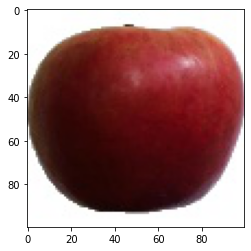

In [9]:
# function for showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_image(*dataset[599])

Label:  Pineapple (99)


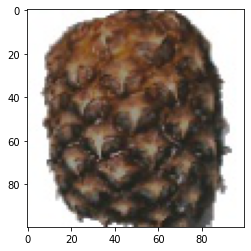

In [10]:
show_image(*dataset[50923])

# **Preparing data for training**

The dataset is split into 3 parts :

* Training set : used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent .

* Validation set : used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.

* Test set : used to compare different models, or different types of modeling approaches, and report the final accuracy of the model. Since there's no predefined validation set, we can set aside a small portion (about 10% of the training dataset) to be used as the validation set. We'll use the random_split helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.



In [11]:
torch.manual_seed(20)
val_size = len(dataset)//10
train_size = len(dataset) - val_size
print(val_size)

6769


In [12]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(60923, 6769)

In [13]:
batch_size = 64
train_loader = DataLoader(train_ds,batch_size,shuffle= True, 
                          num_workers=4, pin_memory=True)

val_loader = DataLoader(val_ds,batch_size*2,num_workers=4, pin_memory=True)

test_loader = DataLoader(test,batch_size*2,num_workers=4, pin_memory=True)

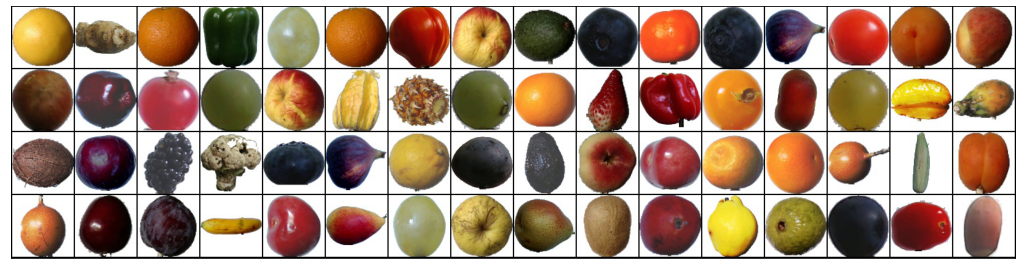

In [14]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# **Feed Forward Neural Network**

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [21]:
input_size = 3*100*100
output_size = 131

In [22]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [23]:
model = to_device(Model(input_size, output_size), device)

In [24]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.006947633344680071, 'val_loss': 4.874475002288818}]

In [25]:
history += fit(7, 0.01, model, train_loader, val_loader)


Epoch [0], train_loss: 4.2976, val_loss: 3.0651, val_acc: 0.1264



Epoch [1], train_loss: 2.2046, val_loss: 1.4134, val_acc: 0.5583



Epoch [2], train_loss: 1.1528, val_loss: 0.6240, val_acc: 0.8165



Epoch [3], train_loss: 0.7146, val_loss: 0.3997, val_acc: 0.8880



Epoch [4], train_loss: 0.4629, val_loss: 0.4106, val_acc: 0.8704



Epoch [5], train_loss: 0.3764, val_loss: 0.3050, val_acc: 0.9177



Epoch [6], train_loss: 0.2368, val_loss: 0.1222, val_acc: 0.9592


In [26]:
history += fit(8, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 0.0695, val_loss: 0.0706, val_acc: 0.9852



Epoch [1], train_loss: 0.0612, val_loss: 0.0666, val_acc: 0.9864



Epoch [2], train_loss: 0.0570, val_loss: 0.0614, val_acc: 0.9875



Epoch [3], train_loss: 0.0534, val_loss: 0.0579, val_acc: 0.9888



Epoch [4], train_loss: 0.0502, val_loss: 0.0553, val_acc: 0.9894



Epoch [5], train_loss: 0.0476, val_loss: 0.0527, val_acc: 0.9891



Epoch [6], train_loss: 0.0452, val_loss: 0.0515, val_acc: 0.9901



Epoch [7], train_loss: 0.0428, val_loss: 0.0495, val_acc: 0.9897


In [27]:
history += fit(3, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 0.0408, val_loss: 0.0465, val_acc: 0.9907



Epoch [1], train_loss: 0.0390, val_loss: 0.0438, val_acc: 0.9925



Epoch [2], train_loss: 0.0373, val_loss: 0.0425, val_acc: 0.9922


# **Model Evaluation for Feed Forward Neural Network**

In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

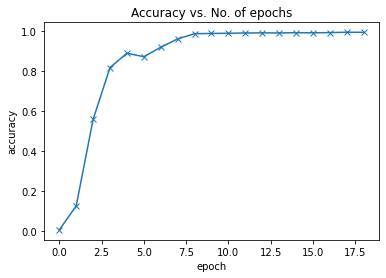

In [29]:
plot_accuracies(history)

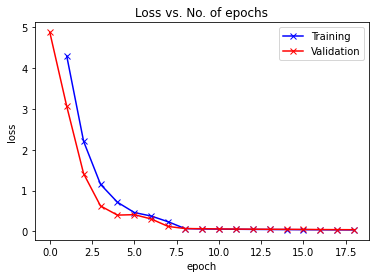

In [30]:
plot_losses(history)

In [31]:
evaluate(model, test_loader)

{'val_acc': 0.9055916666984558, 'val_loss': 0.41948211193084717}

# **Convolutional Neural Network**

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [33]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, 131))
        
    def forward(self, xb):
        return self.network(xb)

In [34]:
model = CnnModel()
model.cuda()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [35]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    #print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 100, 100])
out.shape: torch.Size([64, 131])


In [36]:
device = get_default_device()
device

device(type='cuda')

In [37]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
model = to_device(CnnModel(), device)

In [40]:
history=[evaluate(model, val_loader)]
history

[{'val_acc': 0.005748820956796408, 'val_loss': 4.87622594833374}]

In [41]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

In [42]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.7452, val_loss: 0.2649, val_acc: 0.9118



Epoch [1], train_loss: 0.1625, val_loss: 0.0360, val_acc: 0.9909



Epoch [2], train_loss: 0.0831, val_loss: 0.0503, val_acc: 0.9845


In [43]:
history+= fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.0105, val_loss: 0.0041, val_acc: 0.9987



Epoch [1], train_loss: 0.0046, val_loss: 0.0026, val_acc: 0.9993



Epoch [2], train_loss: 0.0049, val_loss: 0.0025, val_acc: 0.9994


# **Evaluation for CNN**

In [44]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

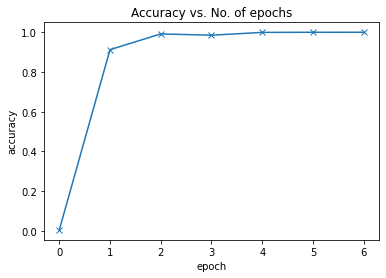

In [45]:
plot_accuracies(history)

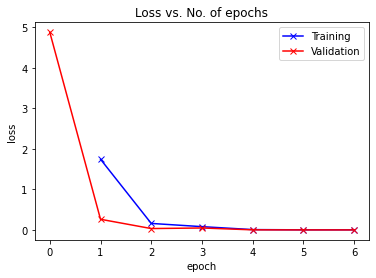

In [46]:
plot_losses(history)

In [47]:
evaluate(model, test_loader)

{'val_acc': 0.9030020833015442, 'val_loss': 0.8167101740837097}